<a href="https://colab.research.google.com/github/isdeniz/roberta-0906/blob/main/bug_clf_to_be_checked_issues_predicted_and_nlbse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers==4.40.2

In [2]:
pip install simpletransformers==0.64.3

In [3]:
import transformers
>>> transformers.__version__

'4.40.2'

In [4]:
import pandas as pd
from functools import partial
import sklearn
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.multiprocessing
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.multiprocessing.set_start_method('spawn', force = True)
pd.set_option('display.max_colwidth', None)
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)
torch.multiprocessing.set_sharing_strategy('file_system')
cuda_available = torch.cuda.is_available()
print("Is cuda available?", cuda_available)

Is cuda available? True


In [5]:
train = pd.read_csv('data/train_df_p.csv')
test = pd.read_csv('data/test_df_p.csv')
print('Number of issues: ', train.shape, test.shape)

Number of issues:  (171392, 3) (19044, 3)


In [6]:
train.head()

,text,labels,labels_name
0,2017-08-03T02:54:12Z NONE facebook/react-native yarnpkg run android taking more than 30 minutes starting package B after installing create react native app and creating a react native app running yarnpkg run android so as to be able to use with my android mobile connected to my pc it takes more than 30 minutes starting package and still doesnt finish it i constantly quit the app what can be done,2,['Resolution: Locked']
1,2016-06-24T00:07:33Z NONE openzipkin/zipkin for exception changing the color to red B hi can we have some feature where if i have a tag added key as exception or error the color changes to red to have it highlighted,1,"['enhancement', 'ui']"
2,2019-04-13T01:41:11Z CONTRIBUTOR apache/pulsar for java functions api improve how message properties can be set for output messages and context published messages B is your feature request related to a problem please describe currently there is no way to specify message properties confs for messages that are return from the functions the api to set those configurations for context publish is not very using friendly describe the solution you d like a builder like api for configuring these message properties confs would be nice for not only messages return by a function but also those published with context publish,1,"['type/feature', 'component/function']"
3,2019-04-10T12:27:49Z CONTRIBUTOR elastic/elasticsearch a cluster with no data nodes or indices reports yellow health when an index is created B if you start up a new cluster without any data nodes then it will report green health because there are no unassigned shards if you subsequently create an index it will report yellow health because there are unassigned newly created primaries however we never attempt to assign any shards if there are no data nodes so the health will continue to report yellow and will never move to red https github com elastic elasticsearch blob abd861bb9191a3e3edd4f92f7d5c586dfa90281d server src main java org elasticsearch cluster routing allocation allocator balancedshardsallocator java l117 l120 i think in this case we should move the unassigned status for any new shards from allocationstatus no attempt to allocationstatus deciders no before bailing out which would result in red health,0,"['>bug', 'good first issue', 'help wanted', ':Distributed/Allocation']"
4,2018-11-05T09:45:59Z NONE spring-projects/spring-boot remove recommendation to add a dependency on woodstox as it s now a transitive dependency of jackson dataformat xml B according to https github com fasterxml woodstox maven the artifact dependency groupid org codehaus woodstox groupid artifactid woodstox core asl artifactid dependency changed to dependency groupid com fasterxml woodstox groupid artifactid woodstox core artifactid dependency should the spring boot documentation reflect this change here https docs spring io spring boot docs 2 1 x reference htmlsingle howto write an xml rest service,2,['type: documentation']


In [7]:
test.head()

,text,labels,labels_name
0,2017-03-04T13:21:53Z NONE facebook/react-native android invokedefaultonbackpressed not triggered anymore on rn 0 42 B previously i can trigger movetasktoback inside invokedefaultonbackpressed like this override public void function function it s work on rn 0 40 until i upgrade to rn 0 42 it didn t trigger anymore when press back button on home page additional information react native version latest 0 42 platform android operating system linux,2,['Resolution: Locked']
1,2016-07-14T00:53:02Z CONTRIBUTOR dbeaver/dbeaver ui bug improvement request import data dialog box B when i import data from another table the records processed message flashes too quickly to be read can you break out the ui on that show it shows records processed and then next line has executing statement or something else you deem appropriate basically i d like to be able to read the message record progress flashes to fast https cloud githubusercontent com assets 9246654 16824683 9b4ca16e 4922 11e6 823f 6683cc9fd178 gif,0,['bug']
2,2018-04-11T16:10:42Z MEMBER elastic/logstash webserver spec randomly fails on concurrent array modification B https logstash ci elastic co job elastic logstash master multijob unix compatibility os centos 46 console sh 05 31 44 1 logstash webserver when an exception occur in the server thread should not log to stderr 05 31 44 failure error status rspec core runner run argv empty junit argv spec argv to i 05 31 44 05 31 44 concurrencyerror 05 31 44 detected invalid array contents due to unsynchronized modifications with concurrent users 05 31 44 var lib jenkins workspace elastic logstash master multijob unix compatibility os centos vendor bundle jruby 2 3 0 gems rspec wait 0 0 9 lib rspec wait rb 46 in block in var lib jenkins workspace elastic logstash master multijob unix compatibility os centos vendor bundle jruby 2 3 0 gems rspec wait 0 0 9 lib rspec wait rb 05 31 44 var lib jenkins workspace elastic logstash master multijob unix compatibility os centos lib bootstrap rspec rb 13 in main 05 31 44 05 31 44 finished in 5 minutes 16 seconds files took 8 89 seconds to load 05 31 44 2745 examples 1 failure 4 pending 05 31 44 05 31 44 failed examples 05 31 44 05 31 44 rspec var lib jenkins workspace elastic logstash master multijob unix compatibility os centos logstash core spec logstash webserver spec rb 55 logstash webserver when an exception occur in the server thread should not log to stderr same spec also randomly fails on sh 22 05 24 failures 22 05 24 22 05 24 1 logstash webserver when an exception occur in the server thread should not log to stderr 22 05 24 failure error function to receive select function at least once 22 05 24 22 05 24 io class select any args 22 05 24 expected at least 1 time with any arguments 22 05 24 received 0 times with any arguments 22 05 24 logstash core spec logstash webserver spec rb 68 in block in root 22 05 24 vendor bundle jruby 2 3 0 gems rspec wait 0 0 9 lib rspec wait rb 46 in block in opt logstash vendor bundle jruby 2 3 0 gems rspec wait 0 0 9 lib rspec wait rb 22 05 24 lib bootstrap rspec rb 13 in main 22 05 24 probably related,2,['test failure']
3,2020-10-18T10:16:42Z NONE facebook/react-native i am closing this issue because it does not appear to have been verified on the latest release and there has been no followup in a while B i also have this problem i have tried the last react native version and that s my react native info system os windows 10 10 0 18362 cpu 8 x64 function function i7 8550u cpu 1 80ghz memory 6 67 gb 15 89 gb binaries node 12 19 0 d work softwear node node exe yarn 1 22 10 d work npmrepo repo yarn cmd npm 6 14 8 d work softwear node npm cmd watchman not found sdks android sdk api levels 29 build tools 28 0 3 29 0 2 system images android 29 intel x86 atom 64 android 29 google play intel x86 atom android ndk not found windows sdk not found ides android studio not found visual studio not found languages java 1 8 0 191 python 2 7 18 npmpackages r

In [8]:
label_encoding = {'bug': 0, 'enhancement': 1, 'out-of-scope': 2, 'to-be-checked': 3}

Removing to-be-checked (3) issues

In [9]:
train_wo_t = train.copy(deep = True)
train_wo_t = train_wo_t[train_wo_t['labels'] != 3]
train_wo_t = train_wo_t.reset_index(drop = True)
train_wo_t.shape[0]

149535

In [10]:
train_wo_t['labels'].value_counts()

labels
2    67113
0    49864
1    32558
Name: count, dtype: int64

In [11]:
test_wo_t = test.copy(deep = True)
test_wo_t = test_wo_t[test_wo_t['labels'] != 3]
test_wo_t = test_wo_t.reset_index(drop = True)
test_wo_t.shape[0]

16615

In [12]:
test_wo_t['labels'].value_counts()

labels
2    7457
0    5540
1    3618
Name: count, dtype: int64

Replacing enhancement (1) and out-of-scope (2) issues as non-bug

In [13]:
train_wo_t['labels'] = train_wo_t['labels'].replace(2, 1)
train_wo_t['labels'].value_counts()

labels
1    99671
0    49864
Name: count, dtype: int64

In [14]:
train_label_perc = train_wo_t['labels'].value_counts(normalize = True) * 100
train_label_perc

labels
1    66.653961
0    33.346039
Name: proportion, dtype: float64

In [15]:
test_wo_t['labels'] = test_wo_t['labels'].replace(2, 1)
test_wo_t['labels'].value_counts()

labels
1    11075
0     5540
Name: count, dtype: int64

In [16]:
test_label_perc = test_wo_t['labels'].value_counts(normalize = True) * 100
test_label_perc

labels
1    66.656636
0    33.343364
Name: proportion, dtype: float64

In [17]:
bug_label_encoding = {'bug': 0, 'non-bug': 1}

Classification model with num_labels = 2

In [18]:
lr = 3e-5
drp = 0
epochs = 4
batch_t = 100
batch_e = 100
# max_seq = 200
max_seq = 300
name = 'roberta'
ver = 'roberta-base'
output_name = 'outputs/' + name

def create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq):
    model_args = ClassificationArgs()
    model_name = name
    model_version = ver
    model_args.learning_rate = lr
    model_args.num_train_epochs = epochs
    model_args.eval_batch_size = batch_t
    model_args.train_batch_size = batch_e
    model_args.max_seq_length = max_seq
    # model_args.n_gpu = 2
    model_args.n_gpu = 1
    model_args.output_dir = output_name +'/'
    model_args.overwrite_output_dir = True
    model_args.reprocess_input_data = True
    model_args.preprocess_inputs = True
    model_args.save_steps = -1
    model_args.save_model_every_epoch = False

    model = ClassificationModel(model_name, model_version, args = model_args,
                                num_labels = 2,
                                use_cuda = cuda_available)

    return model

In [19]:
def calc(p1, p2, func, **kwargs):
    return func(p1, p2, **kwargs)

metrics_recom = {
    "accuracy": partial(calc,func=sklearn.metrics.accuracy_score) ,
    "p_micro": partial(calc,func=sklearn.metrics.precision_score,average='micro'),
    "p_macro": partial(calc,func=sklearn.metrics.precision_score,average='macro'),
    "p_w": partial(calc,func=sklearn.metrics.precision_score,average='weighted'),
    "r_micro": partial(calc,func=sklearn.metrics.recall_score,average='micro'),
    "r_macro": partial(calc,func=sklearn.metrics.recall_score,average='macro'),
    "r_w": partial(calc,func=sklearn.metrics.recall_score,average='weighted'),
    "f_micro": partial(calc,func=sklearn.metrics.f1_score,average='micro'),
    "f_macro": partial(calc,func=sklearn.metrics.f1_score,average='macro'),
    "f_w": partial(calc,func=sklearn.metrics.f1_score,average='weighted'),
    "classificationReport": partial(calc,func=sklearn.metrics.classification_report, output_dict = True)
}

In [20]:
model = create_model(name, ver, lr, drp, epochs, batch_t, batch_e, max_seq)
start = datetime.datetime.now()
print('-'*5,  name, ', start time:',
datetime.datetime.strftime(datetime.datetime.today(), '%d/%m/%Y-%H:%M'), '-'*5)
model.train_model(train_df = train_wo_t, **metrics_recom)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

----- roberta , start time: 09/06/2024-11:47 -----


  0%|          | 0/149535 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/1496 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1496 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1496 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1496 [00:00<?, ?it/s]

(5984, 0.23326335108358373)

In [21]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results, model_outputs, wrong_pred = model.eval_model(test_wo_t, verbose=True, **metrics_recom)
results

----- roberta , duration is: 0h:31m:1s ----- 




  0%|          | 0/16615 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/167 [00:00<?, ?it/s]

{'mcc': 0.7843925675646929,
 'tp': 10297,
 'tn': 4728,
 'fp': 812,
 'fn': 778,
 'auroc': 0.9629452453325292,
 'auprc': 0.9814599022599002,
 'accuracy': 0.9043033403551008,
 'p_micro': 0.9043033403551008,
 'p_macro': 0.8928028562985995,
 'p_w': 0.9041637663918951,
 'r_micro': 0.9043033403551008,
 'r_macro': 0.8915906479451721,
 'r_w': 0.9043033403551008,
 'f_micro': 0.9043033403551008,
 'f_macro': 0.8921916064996269,
 'f_w': 0.9042293954904778,
 'classificationReport': {'0.0': {'precision': 0.8586996004358881,
   'recall': 0.8534296028880867,
   'f1-score': 0.8560564910374796,
   'support': 5540},
  '1.0': {'precision': 0.9269061121613107,
   'recall': 0.9297516930022574,
   'f1-score': 0.9283267219617742,
   'support': 11075},
  'accuracy': 0.9043033403551008,
  'macro avg': {'precision': 0.8928028562985995,
   'recall': 0.8915906479451721,
   'f1-score': 0.8921916064996269,
   'support': 16615},
  'weighted avg': {'precision': 0.9041637663918951,
   'recall': 0.9043033403551008,
   'f

In [22]:
model_outputs.shape[0]

16615

In [23]:
model_outputs_df = pd.DataFrame(model_outputs, columns = ['bug', 'non-bug'])
model_outputs_df.head()

,bug,non-bug
0,-3.781250,3.500000
1,0.479004,-0.596680
2,-2.296875,2.007812
3,-3.044922,2.730469
4,-4.121094,3.839844


In [24]:
def get_prediction(row):
  max_value = row.max()
  if max_value == row['bug']:
    return 0
  elif max_value == row['non-bug']:
    return 1

In [25]:
model_outputs_df['prediction'] = model_outputs_df.apply(get_prediction, axis = 1)
model_outputs_df.head()

,bug,non-bug,prediction
0,-3.781250,3.500000,1
1,0.479004,-0.596680,0
2,-2.296875,2.007812,1
3,-3.044922,2.730469,1
4,-4.121094,3.839844,1


In [26]:
test_wo_t.shape[0]

16615

In [27]:
model_outputs_df['actual'] = test_wo_t['labels']
model_outputs_df.head()

,bug,non-bug,prediction,actual
0,-3.781250,3.500000,1,1
1,0.479004,-0.596680,0,0
2,-2.296875,2.007812,1,1
3,-3.044922,2.730469,1,1
4,-4.121094,3.839844,1,1


In [28]:
label_names = ['bug', 'non-bug']

In [29]:
predicted_labels = model_outputs_df['prediction']
actual_labels = model_outputs_df['actual']

In [30]:
confusion_matrix = confusion_matrix(actual_labels, predicted_labels)
print(confusion_matrix)

[[ 4728   812]
 [  778 10297]]


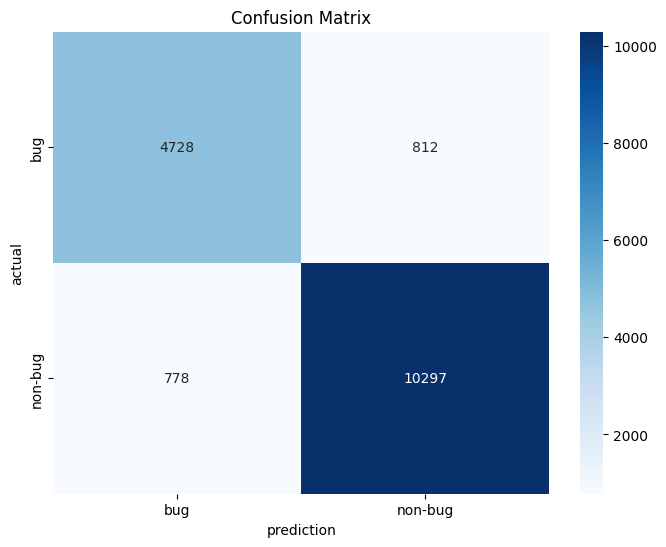

In [31]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
test_wo_t['labels'].value_counts()

labels
1    11075
0     5540
Name: count, dtype: int64

In [33]:
test_label_perc = test_wo_t['labels'].value_counts(normalize = True) * 100
test_label_perc

labels
1    66.656636
0    33.343364
Name: proportion, dtype: float64

In [34]:
predicted_labels.head()

0    1
1    0
2    1
3    1
4    1
Name: prediction, dtype: int64

In [35]:
predicted_labels.shape[0]

16615

In [36]:
actual_labels.head()

0    1
1    0
2    1
3    1
4    1
Name: actual, dtype: int64

In [37]:
actual_labels.shape[0]

16615

In [38]:
test_wo_t.head(2)

,text,labels,labels_name
0,2017-03-04T13:21:53Z NONE facebook/react-native android invokedefaultonbackpressed not triggered anymore on rn 0 42 B previously i can trigger movetasktoback inside invokedefaultonbackpressed like this override public void function function it s work on rn 0 40 until i upgrade to rn 0 42 it didn t trigger anymore when press back button on home page additional information react native version latest 0 42 platform android operating system linux,1,['Resolution: Locked']
1,2016-07-14T00:53:02Z CONTRIBUTOR dbeaver/dbeaver ui bug improvement request import data dialog box B when i import data from another table the records processed message flashes too quickly to be read can you break out the ui on that show it shows records processed and then next line has executing statement or something else you deem appropriate basically i d like to be able to read the message record progress flashes to fast https cloud githubusercontent com assets 9246654 16824683 9b4ca16e 4922 11e6 823f 6683cc9fd178 gif,0,['bug']


In [39]:
prediction_test_wo_t = pd.DataFrame(columns = ['text', 'labels', 'actual_labels', 'prediction', 'labels_name'])

In [40]:
prediction_test_wo_t['text'] = test_wo_t['text']
prediction_test_wo_t['labels'] = test_wo_t['labels']
prediction_test_wo_t['actual_labels'] = model_outputs_df['actual']
prediction_test_wo_t['prediction'] = model_outputs_df['prediction']
prediction_test_wo_t['labels_name'] = test_wo_t['labels_name']
prediction_test_wo_t.head()

,text,labels,actual_labels,prediction,labels_name
0,2017-03-04T13:21:53Z NONE facebook/react-native android invokedefaultonbackpressed not triggered anymore on rn 0 42 B previously i can trigger movetasktoback inside invokedefaultonbackpressed like this override public void function function it s work on rn 0 40 until i upgrade to rn 0 42 it didn t trigger anymore when press back button on home page additional information react native version latest 0 42 platform android operating system linux,1,1,1,['Resolution: Locked']
1,2016-07-14T00:53:02Z CONTRIBUTOR dbeaver/dbeaver ui bug improvement request import data dialog box B when i import data from another table the records processed message flashes too quickly to be read can you break out the ui on that show it shows records processed and then next line has executing statement or something else you deem appropriate basically i d like to be able to read the message record progress flashes to fast https cloud githubusercontent com assets 9246654 16824683 9b4ca16e 4922 11e6 823f 6683cc9fd178 gif,0,0,0,['bug']
2,2018-04-11T16:10:42Z MEMBER elastic/logstash webserver spec randomly fails on concurrent array modification B https logstash ci elastic co job elastic logstash master multijob unix compatibility os centos 46 console sh 05 31 44 1 logstash webserver when an exception occur in the server thread should not log to stderr 05 31 44 failure error status rspec core runner run argv empty junit argv spec argv to i 05 31 44 05 31 44 concurrencyerror 05 31 44 detected invalid array contents due to unsynchronized modifications with concurrent users 05 31 44 var lib jenkins workspace elastic logstash master multijob unix compatibility os centos vendor bundle jruby 2 3 0 gems rspec wait 0 0 9 lib rspec wait rb 46 in block in var lib jenkins workspace elastic logstash master multijob unix compatibility os centos vendor bundle jruby 2 3 0 gems rspec wait 0 0 9 lib rspec wait rb 05 31 44 var lib jenkins workspace elastic logstash master multijob unix compatibility os centos lib bootstrap rspec rb 13 in main 05 31 44 05 31 44 finished in 5 minutes 16 seconds files took 8 89 seconds to load 05 31 44 2745 examples 1 failure 4 pending 05 31 44 05 31 44 failed examples 05 31 44 05 31 44 rspec var lib jenkins workspace elastic logstash master multijob unix compatibility os centos logstash core spec logstash webserver spec rb 55 logstash webserver when an exception occur in the server thread should not log to stderr same spec also randomly fails on sh 22 05 24 failures 22 05 24 22 05 24 1 logstash webserver when an exception occur in the server thread should not log to stderr 22 05 24 failure error function to receive select function at least once 22 05 24 22 05 24 io class select any args 22 05 24 expected at least 1 time with any arguments 22 05 24 received 0 times with any arguments 22 05 24 logstash core spec logstash webserver spec rb 68 in block in root 22 05 24 vendor bundle jruby 2 3 0 gems rspec wait 0 0 9 lib rspec wait rb 46 in block in opt logstash vendor bundle jruby 2 3 0 gems rspec wait 0 0 9 lib rspec wait rb 22 05 24 lib bootstrap rspec rb 13 in main 22 05 24 probably related,1,1,1,['test failure']
3,2020-10-18T10:16:42Z NONE facebook/react-native i am closing this issue because it does not appear to have been verified on the latest release and there has been no followup in a while B i also have this problem i have tried the last react native version and that s my react native info system os windows 10 10 0 18362 cpu 8 x64 function function i7 8550u cpu 1 80ghz memory 6 67 gb 15 89 gb binaries node 12 19 0 d work softwear node node exe yarn 1 22 10 d work npmrepo repo yarn cmd npm 6 14 8 d work softwear node npm cmd watchman not found sdks android sdk api levels 29 build tools 28 0 3 29 0 2 system images android 29 intel x86 atom 64 android 29 google play intel x86 atom android ndk not found windows sdk not found ides android studio not found visual studio not found languages java 

In [41]:
prediction_test_wo_t.to_csv('data/prediction_test_bug_classifier_p_0906.csv')

Performance on training set

In [42]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results_train, model_outputs_train, wrong_pred_train = model.eval_model(train_wo_t, verbose=True, **metrics_recom)
results_train

----- roberta , duration is: 0h:36m:21s ----- 




  0%|          | 0/149535 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1496 [00:00<?, ?it/s]

{'mcc': 0.875243609050214,
 'tp': 95245,
 'tn': 45973,
 'fp': 3891,
 'fn': 4426,
 'auroc': 0.9858569240772622,
 'auprc': 0.9931454501617978,
 'accuracy': 0.9443809141672518,
 'p_micro': 0.9443809141672518,
 'p_macro': 0.9364658424537523,
 'p_w': 0.9445546861830396,
 'r_micro': 0.9443809141672518,
 'r_macro': 0.9387808281150971,
 'r_w': 0.9443809141672518,
 'f_micro': 0.9443809141672518,
 'f_macro': 0.9376068101405761,
 'f_w': 0.9444544680244987,
 'classificationReport': {'0.0': {'precision': 0.9121807972380405,
   'recall': 0.9219677522862185,
   'f1-score': 0.917048163330441,
   'support': 49864},
  '1.0': {'precision': 0.9607508876694641,
   'recall': 0.9555939039439757,
   'f1-score': 0.9581654569507111,
   'support': 99671},
  'accuracy': 0.9443809141672518,
  'macro avg': {'precision': 0.9364658424537523,
   'recall': 0.9387808281150971,
   'f1-score': 0.9376068101405761,
   'support': 149535},
  'weighted avg': {'precision': 0.9445546861830396,
   'recall': 0.9443809141672518,
  

In [43]:
model_outputs_train.shape[0]

149535

In [44]:
model_outputs_df_train = pd.DataFrame(model_outputs_train, columns = ['bug', 'non-bug'])
model_outputs_df_train.head()

,bug,non-bug
0,-4.023438,3.746094
1,-3.761719,3.496094
2,-2.478516,2.376953
3,1.625977,-1.563477
4,-3.726562,3.408203


In [45]:
model_outputs_df_train['prediction'] = model_outputs_df_train.apply(get_prediction, axis = 1)
model_outputs_df_train.head()

,bug,non-bug,prediction
0,-4.023438,3.746094,1
1,-3.761719,3.496094,1
2,-2.478516,2.376953,1
3,1.625977,-1.563477,0
4,-3.726562,3.408203,1


In [46]:
train_wo_t.shape[0]

149535

In [47]:
model_outputs_df_train['actual'] = train_wo_t['labels']
model_outputs_df_train.head()

,bug,non-bug,prediction,actual
0,-4.023438,3.746094,1,1
1,-3.761719,3.496094,1,1
2,-2.478516,2.376953,1,1
3,1.625977,-1.563477,0,0
4,-3.726562,3.408203,1,1


In [48]:
predicted_labels_train = model_outputs_df_train['prediction']
actual_labels_train = model_outputs_df_train['actual']

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
confusion_matrix_train = confusion_matrix(actual_labels_train, predicted_labels_train)
print(confusion_matrix_train)

[[45973  3891]
 [ 4426 95245]]


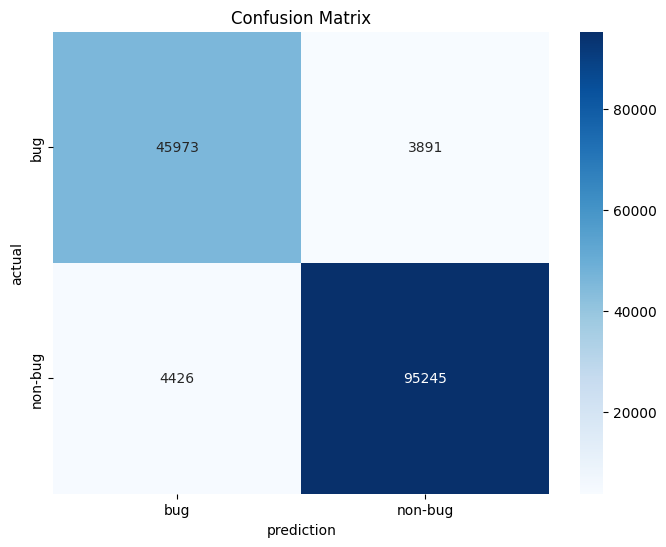

In [51]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix_train,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

In [52]:
train_wo_t['labels'].value_counts()

labels
1    99671
0    49864
Name: count, dtype: int64

In [53]:
train_label_perc = train_wo_t['labels'].value_counts(normalize = True) * 100
train_label_perc

labels
1    66.653961
0    33.346039
Name: proportion, dtype: float64

In [54]:
prediction_train_wo_t = pd.DataFrame(columns = ['text', 'labels', 'actual_labels', 'prediction', 'labels_name'])

In [55]:
prediction_train_wo_t['text'] = train_wo_t['text']
prediction_train_wo_t['labels'] = train_wo_t['labels']
prediction_train_wo_t['actual_labels'] = model_outputs_df_train['actual']
prediction_train_wo_t['prediction'] = model_outputs_df_train['prediction']
prediction_train_wo_t['labels_name'] = train_wo_t['labels_name']
prediction_train_wo_t.head()

,text,labels,actual_labels,prediction,labels_name
0,2017-08-03T02:54:12Z NONE facebook/react-native yarnpkg run android taking more than 30 minutes starting package B after installing create react native app and creating a react native app running yarnpkg run android so as to be able to use with my android mobile connected to my pc it takes more than 30 minutes starting package and still doesnt finish it i constantly quit the app what can be done,1,1,1,['Resolution: Locked']
1,2016-06-24T00:07:33Z NONE openzipkin/zipkin for exception changing the color to red B hi can we have some feature where if i have a tag added key as exception or error the color changes to red to have it highlighted,1,1,1,"['enhancement', 'ui']"
2,2019-04-13T01:41:11Z CONTRIBUTOR apache/pulsar for java functions api improve how message properties can be set for output messages and context published messages B is your feature request related to a problem please describe currently there is no way to specify message properties confs for messages that are return from the functions the api to set those configurations for context publish is not very using friendly describe the solution you d like a builder like api for configuring these message properties confs would be nice for not only messages return by a function but also those published with context publish,1,1,1,"['type/feature', 'component/function']"
3,2019-04-10T12:27:49Z CONTRIBUTOR elastic/elasticsearch a cluster with no data nodes or indices reports yellow health when an index is created B if you start up a new cluster without any data nodes then it will report green health because there are no unassigned shards if you subsequently create an index it will report yellow health because there are unassigned newly created primaries however we never attempt to assign any shards if there are no data nodes so the health will continue to report yellow and will never move to red https github com elastic elasticsearch blob abd861bb9191a3e3edd4f92f7d5c586dfa90281d server src main java org elasticsearch cluster routing allocation allocator balancedshardsallocator java l117 l120 i think in this case we should move the unassigned status for any new shards from allocationstatus no attempt to allocationstatus deciders no before bailing out which would result in red health,0,0,0,"['>bug', 'good first issue', 'help wanted', ':Distributed/Allocation']"
4,2018-11-05T09:45:59Z NONE spring-projects/spring-boot remove recommendation to add a dependency on woodstox as it s now a transitive dependency of jackson dataformat xml B according to https github com fasterxml woodstox maven the artifact dependency groupid org codehaus woodstox groupid artifactid woodstox core asl artifactid dependency changed to dependency groupid com fasterxml woodstox groupid artifactid woodstox core artifactid dependency should the spring boot documentation reflect this change here https docs spring io spring boot docs 2 1 x reference htmlsingle howto write an xml rest service,1,1,1,['type: documentation']


In [56]:
prediction_train_wo_t.tail()

,text,labels,actual_labels,prediction,labels_name
149530,2020-03-24T09:32:10Z COLLABORATOR dbeaver/dbeaver exasol support consumer groups in exasol 7 0 B is your feature request related to a problem please describe the priority groups are removed in version 7 0 of exasol describe the solution you d like support for consumer groups have to be implemented describe alternatives you ve considered none additional context currently dbeaver throws an exception when accessing priority groups in v7 0,1,1,1,['feature request']
149531,2022-08-25T08:21:24Z CONTRIBUTOR apache/shardingsphere cannot add resources after discovery rules created B bug report which version of shardingsphere did you use master 6cf1f1e8352d7be5c501a5626ef44e708a5b0d2b which project did you use shardingsphere jdbc or shardingsphere proxy shardingsphere proxy expected behavior add resource success actual behavior got an exception and add resource failed steps to reproduce the behavior such as sql to execute sharding rule configuration when exception occur etc 1 add resources ds 0 ds 1 ds 2 add resource ds 0 url jdbc mysql xxx xx xx xx 33306 primary demo ds servertimezone utc usessl false user root password xxxxxx ds 1 url jdbc mysql xxx xx xx xx 33307 primary demo ds servertimezone utc usessl false user root password xxxxxx ds 2 url jdbc mysql xxx xx xx xx 33308 primary demo ds servertimezone utc usessl false user root password xxxxxx 2 create database discover rule group0 create db discovery rule group 0 function type name mysql mgr properties group name 558edd3c 02ec 11ea 9bb3 080027e39bd2 heartbeat properties keep alive cron 0 5 3 add resource resource 0 add resource resource 0 host 127 0 0 1 port 3306 db db0 user root password 123456 log error 1999 42000 unknown exception java lang nullpointerexception,0,0,1,"['type: bug', 'feature: db-discovery', 'feature: DistSQL']"
149532,2017-12-07T16:05:45Z COLLABORATOR spring-projects/spring-framework introduce ability to not encode uris with uritemplate spr 16279 B greg turnquist https jira spring io secure viewprofile jspa name gregturn opened spr 16279 https jira spring io browse spr 16279 redirect false and commented spring hateoas leverage s spring framework s uritemplate class however in certain scenarios the user provides a uri template that is already encoded e g foo b 20ar x in this scenario when creating a spring framework uritemplate the gets encoded into 25 and because we wrap this some of our own goodness it actually gets encoded twice when doing an expand e g x 1 in this case it would be useful if there was an optional to indicate do not encode possibly here public uri expand map string urivariables uricomponents expandedcomponents function uricomponents encodedcomponents function return function a flag here or an overloaded method to side step encoding would make it possible related issue reference url https github com spring projects spring hateoas issues 593,1,1,1,"['in: web', 'status: declined', 'type: enhancement']"
149533,2021-07-16T10:32:06Z NONE zaproxy/zaproxy failed to read https xxx xxx xxx within 20 seconds B describe the bug can t use zaproxy docker installation behind a reverse proxy nginx to reproduce install docker docker compose docker compose yml version 3 6 services owasp restart unless stopped user zap ports 8080 8080 image owasp zap2docker stable command zap sh daemon host 0 0 0 0 port 8080 config api addrs addr name config api addrs addr regex true config api key api key docker compose up d nginx configuration nginx map http upgrade connection upgrade default upgrade close server listen 443 ssl http2 listen 433 ssl http2 server name xxx xxx xxx location add header strict transport security max age 31536000 always proxy set header upgrade http upgrade proxy set header connection connection upgrade proxy pass https localhost 8080 include etc nginx proxy params ssl certificate etc letsencrypt live xxx xxx xxx fullchain pem managed by certbot ssl certificate key etc letsencrypt live xxx xxx 

In [57]:
prediction_train_wo_t.to_csv('data/prediction_train_bug_classifier_p_0906.csv')

Predicting to-be-checked issues

In [58]:
train_t = train.copy(deep = True)
train_t = train_t[train_t['labels'] == 3]
train_t = train_t.reset_index(drop = True)
train_t.shape[0]

21857

In [59]:
train_t['labels'].value_counts()

labels
3    21857
Name: count, dtype: int64

In [60]:
test_t = test.copy(deep = True)
test_t = test_t[test_t['labels'] == 3]
test_t = test_t.reset_index(drop = True)
test_t.shape[0]

2429

In [61]:
test_t['labels'].value_counts()

labels
3    2429
Name: count, dtype: int64

In [62]:
to_be_checked_issues = pd.concat([train_t, test_t], ignore_index = True)
to_be_checked_issues = to_be_checked_issues.reset_index(drop = True)
to_be_checked_issues.shape[0]

24286

In [63]:
to_be_checked_issues.head()

,text,labels,labels_name
0,2020-03-03T05:03:38Z NONE pinpoint-apm/pinpoint transid is passed across the thread pool in asynchronous execution B i hope that i can provide a solution for the transfer of transid across threads and thread pools in asynchronous execution recently i saw an open source class library of alibaba i think it may be helpful for this i hope that i can support transid asynchronous across thread pools as soon as possible transfer https github com alibaba transmittable thread local,3,['stale']
1,2016-12-12T20:33:12Z MEMBER apache/druid implement function and avoid deleting off heap cache while lookupextractor is in use B addressing https github com druid io druid blob 78159d7ca442cf8d99ea356d39932ab3adb8e10f extensions core lookups cached global src main java io druid server lookup namespace cache offheapnamespaceextractioncachemanager java l122 proposed solution make lookupextractor closeable and remove the cache only after it is replaced by a newer cache via periodic updates and there are no open lookupextractor s accessing this cache implementation may require some kind of manual reference counting currently because of issue while off heap cache is not functional so this issue is not important because closing on heap cache while using it is harmless closing is just cleaning references to it the cache itself is unchanged,3,"['Area - Lookups', 'stale']"
2,2015-07-24T13:58:06Z CONTRIBUTOR apache/druid transient test failure in remotetaskrunnertest B build https travis ci org druid io druid jobs 72409712 log tests run 15 failures 1 errors 0 skipped 0 time elapsed 27 976 sec failure in io druid indexing overlord remotetaskrunnertest testrunexistingtaskthathasntstartedrunning io druid indexing overlord remotetaskrunnertest time elapsed 2 888 sec failure java lang assertionerror expected success but was failed at org junit assert fail assert java 88 at org junit assert failnotequals assert java 743 at org junit assert assertequals assert java 118 at org junit assert assertequals assert java 144 at io druid indexing overlord remotetaskrunnertest testrunexistingtaskthathasntstartedrunning remotetaskrunnertest java 151 running io druid indexing overlord tasklifecycletest tests run 22 failures 0 errors 0 skipped 0 time elapsed 15 363 sec in io druid indexing overlord tasklifecycletest running io druid indexing overlord http overlordresourcetest tests run 1 failures 0 errors 0 skipped 0 time elapsed 2 174 sec in io druid indexing overlord http overlordresourcetest running io druid indexing common config taskstorageconfigtest,3,['stale']
3,2018-03-13T11:48:17Z NONE elastic/elasticsearch reindex loosing the data B reindex api is not creating all the documents from source index to dest index response says it got updated some documents but there were no documents exists to update it was a newly created index it has to create all the documents can anyone help me understand whats wrong going on here timed out false noops 0 total 19575 failures updated 4821 deleted 0 requests per second 1 0 batches 22 throttled millis 0 version conflicts 0 throttled until millis 0 took 88987 created 14754 retries bulk 0 search 0 slices slice id 0 noops 0 total 1947 updated 236 deleted 0 requests per second 1 0 batches 2 throttled millis 0 version conflicts 0 throttled until millis 0 created 1711 retries bulk 0 search 0 slice id 1 noops 0 total 1942 updated 188 deleted 0 requests per second 1 0 batches 2 throttled millis 0 version conflicts 0 throttled until millis 0 created 1754 retries bulk 0 search 0 slice id 2 noops 0 total 1938 updated 241 deleted 0 requests per second 1 0 batches 2 throttled millis 0 version conflicts 0 throttled until millis 0 created 1697 retries bulk 0 search 0 slice id 3 noops 0 total 1918 updated 339 deleted 0 requests per second 1 0 batches 2 throttled millis 0 version conflicts 0 throttled until millis 0 created 1579 retries bulk 0 search 0 slice id 4 noops 0 total 1960 updated 173 deleted 0 requests per second 1

In [64]:
to_be_checked_issues.tail()

text  \
24281                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        2021-06-10T08:55:14Z NONE spring-projects/spring-boot sqlinitializationautoconfiguration fails when there is a datasource bean and no spring jdbc or a connectionfactory bean and no spring r2dbc B sqlinitializationautoconfiguration throws java lang classnotfoundexception org springframework jdbc datasource init databasepopulator without spring jdbc sqlinitializationautoconfiguration should be skipped when databasepopulator from spring jdbc is unavailable my application does not need spring jdbc or any database initialization as a workaround i use springbootapplication exclude sqlinitializationautoconfiguration class sqlinitializationautoconfiguration was added in spring boot 2 5 0 https github com spring projects spring boot issues 25323 the full stack trace org springframework beans factory beancreationexception error creating bean with name datasourcescriptdatabaseinitializer defined in class path resource org springframework boot autoconfigure sql init datasourceinitializationconfigura tion class bean instantiation via factory method failed nested exception is org springframework beans beaninstantiationexception failed to instantiate org springframework boot jdbc init datasourcescriptdatabaseinitializer factory m ethod datasourcescriptdatabaseinitializer threw exception nested exception is java lang noclassdeffounderror org springframework jdbc datasource init databasepopulator at org springframework beans factory support constructorresolver instantiate constructorresolver java 658 spring beans 5 3 7 jar 5 3 7 at org springframework beans factory support constructorresolver instantiateusingfactorymethod constructorresolver java 638 spring beans 5 3 7 jar 5 3 7 at org springframework beans factory support abstractautowirecapablebeanfactory instantiateusingfactorymethod abstractautowirecapablebeanfactory java 1334 spring beans 5 3 7 jar 5 3 7 at org springframework beans factory support abstractautowirecapablebeanfactory createbeaninstance abstractautowirecapablebeanfactory java 1177 spring beans 5 3 7 jar 5 3 7 at org springframework beans factory support abstractautowirecapablebeanfactory docreatebean abstractautowirecapablebeanfactory java 564 spring beans 5 3 7 jar 5 3 7 at org springframework beans factory 

In [65]:
pred, raw_outputs = model.predict(to_be_checked_issues['text'].tolist())

  0%|          | 0/24286 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

In [66]:
pred

array([1, 1, 1, ..., 1, 1, 0])

In [67]:
raw_outputs

array([[-1.03125   ,  0.87011719],
       [-3.83984375,  3.52734375],
       [-3.10546875,  2.76953125],
       ...,
       [-3.23632812,  2.953125  ],
       [-3.04296875,  2.8203125 ],
       [ 1.546875  , -1.5078125 ]])

In [68]:
prediction_to_be_checked = pd.DataFrame(columns = ['text', 'prediction', 'labels_name'])

In [69]:
prediction_to_be_checked['text'] = to_be_checked_issues['text']
prediction_to_be_checked['labels_name'] = to_be_checked_issues['labels_name']

In [70]:
pred_df = pd.DataFrame(pred, columns = ['prediction'])
pred_df.head()

,prediction
0,1
1,1
2,1
3,1
4,1


In [71]:
prediction_to_be_checked['prediction'] = pred_df['prediction']

In [72]:
prediction_to_be_checked.head()

,text,prediction,labels_name
0,2020-03-03T05:03:38Z NONE pinpoint-apm/pinpoint transid is passed across the thread pool in asynchronous execution B i hope that i can provide a solution for the transfer of transid across threads and thread pools in asynchronous execution recently i saw an open source class library of alibaba i think it may be helpful for this i hope that i can support transid asynchronous across thread pools as soon as possible transfer https github com alibaba transmittable thread local,1,['stale']
1,2016-12-12T20:33:12Z MEMBER apache/druid implement function and avoid deleting off heap cache while lookupextractor is in use B addressing https github com druid io druid blob 78159d7ca442cf8d99ea356d39932ab3adb8e10f extensions core lookups cached global src main java io druid server lookup namespace cache offheapnamespaceextractioncachemanager java l122 proposed solution make lookupextractor closeable and remove the cache only after it is replaced by a newer cache via periodic updates and there are no open lookupextractor s accessing this cache implementation may require some kind of manual reference counting currently because of issue while off heap cache is not functional so this issue is not important because closing on heap cache while using it is harmless closing is just cleaning references to it the cache itself is unchanged,1,"['Area - Lookups', 'stale']"
2,2015-07-24T13:58:06Z CONTRIBUTOR apache/druid transient test failure in remotetaskrunnertest B build https travis ci org druid io druid jobs 72409712 log tests run 15 failures 1 errors 0 skipped 0 time elapsed 27 976 sec failure in io druid indexing overlord remotetaskrunnertest testrunexistingtaskthathasntstartedrunning io druid indexing overlord remotetaskrunnertest time elapsed 2 888 sec failure java lang assertionerror expected success but was failed at org junit assert fail assert java 88 at org junit assert failnotequals assert java 743 at org junit assert assertequals assert java 118 at org junit assert assertequals assert java 144 at io druid indexing overlord remotetaskrunnertest testrunexistingtaskthathasntstartedrunning remotetaskrunnertest java 151 running io druid indexing overlord tasklifecycletest tests run 22 failures 0 errors 0 skipped 0 time elapsed 15 363 sec in io druid indexing overlord tasklifecycletest running io druid indexing overlord http overlordresourcetest tests run 1 failures 0 errors 0 skipped 0 time elapsed 2 174 sec in io druid indexing overlord http overlordresourcetest running io druid indexing common config taskstorageconfigtest,1,['stale']
3,2018-03-13T11:48:17Z NONE elastic/elasticsearch reindex loosing the data B reindex api is not creating all the documents from source index to dest index response says it got updated some documents but there were no documents exists to update it was a newly created index it has to create all the documents can anyone help me understand whats wrong going on here timed out false noops 0 total 19575 failures updated 4821 deleted 0 requests per second 1 0 batches 22 throttled millis 0 version conflicts 0 throttled until millis 0 took 88987 created 14754 retries bulk 0 search 0 slices slice id 0 noops 0 total 1947 updated 236 deleted 0 requests per second 1 0 batches 2 throttled millis 0 version conflicts 0 throttled until millis 0 created 1711 retries bulk 0 search 0 slice id 1 noops 0 total 1942 updated 188 deleted 0 requests per second 1 0 batches 2 throttled millis 0 version conflicts 0 throttled until millis 0 created 1754 retries bulk 0 search 0 slice id 2 noops 0 total 1938 updated 241 deleted 0 requests per second 1 0 batches 2 throttled millis 0 version conflicts 0 throttled until millis 0 created 1697 retries bulk 0 search 0 slice id 3 noops 0 total 1918 updated 339 deleted 0 requests per second 1 0 batches 2 throttled millis 0 version conflicts 0 throttled until millis 0 created 1579 retries bulk 0 search 0 slice id 4 noops 0 total 1960 updated 173 deleted 0 requests per seco

In [73]:
prediction_to_be_checked['prediction'].value_counts()

prediction
1    14250
0    10036
Name: count, dtype: int64

In [74]:
prediction_to_be_checked.to_csv('data/prediction_to_be_checked_bug_classifier_p_0906.csv')

Trying this model on NLBSE'22 dataset with our preprocessing steps

In [75]:
nlbse_1 = pd.read_csv('data/nlbse_p_part1.csv')
print('Number of issues in part 1: ', nlbse_1.shape)

Number of issues in part 1:  (192847, 2)


In [76]:
nlbse_2 = pd.read_csv('data/nlbse_p_part2.csv')
print('Number of issues in part 2: ', nlbse_2.shape)

Number of issues in part 2:  (192847, 2)


In [77]:
nlbse_3 = pd.read_csv('data/nlbse_p_part3.csv')
print('Number of issues in part 3: ', nlbse_3.shape)

Number of issues in part 3:  (192847, 2)


In [78]:
nlbse_4 = pd.read_csv('data/nlbse_p_part4.csv')
print('Number of issues in part 4: ', nlbse_4.shape)

Number of issues in part 4:  (192850, 2)


In [79]:
nlbse_full_df = pd.concat([nlbse_1, nlbse_2], ignore_index = True)
nlbse_full_df = pd.concat([nlbse_full_df, nlbse_3], ignore_index = True)
nlbse_full_df = pd.concat([nlbse_full_df, nlbse_4], ignore_index = True)

In [80]:
nlbse_full_df.reset_index(drop = True, inplace = True)

In [81]:
nlbse_full_df.shape[0]

771391

In [82]:
nlbse_full_df.head()

,text,labels
0,2021-05-26T20:57:00Z OWNER 0-Yama/Projet-Final-Python the beginning B we need to add the first file of our project,1
1,2020-07-26T20:14:04Z OWNER 0-vortex/dotfiles better touch tool configuration B export better touch tool configuration as a separate package or submodule,1
2,2020-12-04T09:33:18Z NONE 00-Evan/shattered-pixel-dungeon request text when wand of regrowth starts producing furrowed grass B i was super confused when this happened a bit of text would have helped me realize what was going on a lot sooner the wand is getting old and the new grass is not as healthy,1
3,2021-01-28T14:52:15Z NONE 00-Evan/shattered-pixel-dungeon item renaming does not worked as expected B found that the enchantment name blazing chilling etc and enhancement level xxx is still there after i renamed an item for instance a chilling runic blade 8 given a name let s say frostmourne will be a chilling frostmourne 8 instead hope you can have it fixed in future versions,1
4,2021-03-06T17:12:01Z NONE 00-Evan/shattered-pixel-dungeon option to disable dim screen flash when getting blinded B when my character is getting blinded the screen flashes completly white which in turn also flashes me as the player it makes sense mechanic wise but it is hurting my eyes whenever it occurs i would like to have an option to either disable or dim the flash,1


In [83]:
nlbse_full_df['labels'].value_counts()

labels
0    385155
1    321043
2     65193
Name: count, dtype: int64

Replacing enhancement (1) and question (2) issues as non-bug

In [84]:
nlbse_bug = nlbse_full_df.copy(deep = True)

In [85]:
nlbse_bug['labels'] = nlbse_bug['labels'].replace(2, 1)
nlbse_bug['labels'].value_counts()

labels
1    386236
0    385155
Name: count, dtype: int64

In [86]:
nlbse_bug_perc = nlbse_bug['labels'].value_counts(normalize = True) * 100
nlbse_bug_perc

labels
1    50.070068
0    49.929932
Name: proportion, dtype: float64

In [87]:
hours, remainder = divmod((datetime.datetime.now() - start).total_seconds(), 3600)
minutes, seconds = divmod(remainder, 60)
print('-'*5,  name, ', duration is:', '%dh:%dm:%ds' % (hours, minutes, seconds), '-'*5, '\n\n')
results_nlbse, model_outputs_nlbse, wrong_pred_nlbse = model.eval_model(nlbse_bug, verbose=True, **metrics_recom)
results_nlbse

----- roberta , duration is: 3h:2m:13s ----- 




  0%|          | 0/771391 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/7714 [00:00<?, ?it/s]

{'mcc': 0.6562429244461078,
 'tp': 349497,
 'tn': 286002,
 'fp': 99153,
 'fn': 36739,
 'auroc': 0.9068509557625206,
 'auprc': 0.8927472993389834,
 'accuracy': 0.8238351238217713,
 'p_micro': 0.8238351238217713,
 'p_macro': 0.8325813390049464,
 'p_w': 0.8325062477992897,
 'r_micro': 0.8238351238217713,
 'r_macro': 0.8237213918661677,
 'r_w': 0.8238351238217713,
 'f_micro': 0.8238351238217714,
 'f_macro': 0.8226334081052356,
 'f_w': 0.8226538672703599,
 'classificationReport': {'0.0': {'precision': 0.886165687036974,
   'recall': 0.7425633835728473,
   'f1-score': 0.8080339484896086,
   'support': 385155},
  '1.0': {'precision': 0.7789969909729187,
   'recall': 0.904879400159488,
   'f1-score': 0.8372328677208626,
   'support': 386236},
  'accuracy': 0.8238351238217713,
  'macro avg': {'precision': 0.8325813390049464,
   'recall': 0.8237213918661677,
   'f1-score': 0.8226334081052356,
   'support': 771391},
  'weighted avg': {'precision': 0.8325062477992897,
   'recall': 0.82383512382177

In [88]:
model_outputs_nlbse.shape[0]

771391

In [89]:
model_outputs_df_nlbse = pd.DataFrame(model_outputs_nlbse, columns = ['bug', 'non-bug'])
model_outputs_df_nlbse.head()

,bug,non-bug
0,-4.136719,3.718750
1,-2.677734,2.550781
2,-2.750000,2.462891
3,1.468750,-1.428711
4,-2.564453,2.398438


In [90]:
model_outputs_df_nlbse['prediction'] = model_outputs_df_nlbse.apply(get_prediction, axis = 1)
model_outputs_df_nlbse.head()

,bug,non-bug,prediction
0,-4.136719,3.718750,1
1,-2.677734,2.550781,1
2,-2.750000,2.462891,1
3,1.468750,-1.428711,0
4,-2.564453,2.398438,1


In [91]:
nlbse_bug.shape[0]

771391

In [92]:
model_outputs_df_nlbse['actual'] = nlbse_bug['labels']
model_outputs_df_nlbse.head()

,bug,non-bug,prediction,actual
0,-4.136719,3.718750,1,1
1,-2.677734,2.550781,1,1
2,-2.750000,2.462891,1,1
3,1.468750,-1.428711,0,1
4,-2.564453,2.398438,1,1


In [93]:
predicted_labels_nlbse = model_outputs_df_nlbse['prediction']
actual_labels_nlbse = model_outputs_df_nlbse['actual']

In [94]:
from sklearn.metrics import confusion_matrix

In [95]:
confusion_matrix_nlbse = confusion_matrix(actual_labels_nlbse, predicted_labels_nlbse)
print(confusion_matrix_nlbse)

[[286002  99153]
 [ 36739 349497]]


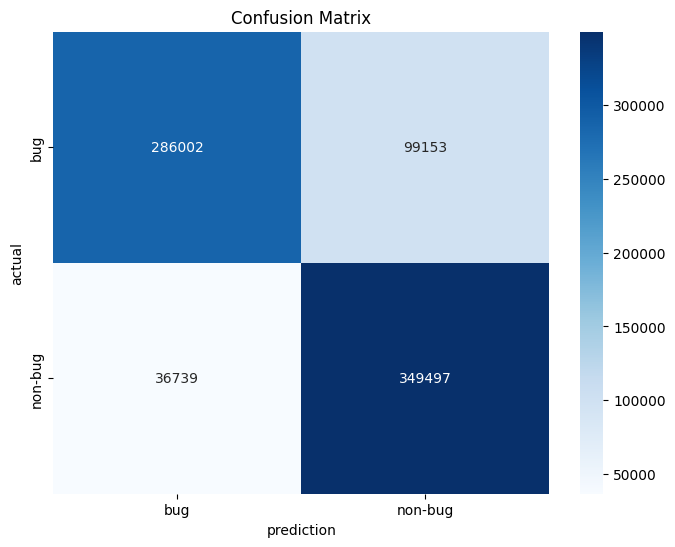

In [96]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix_nlbse,
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_names,
            yticklabels = label_names)
plt.xlabel('prediction')
plt.ylabel('actual')
plt.title('Confusion Matrix')
plt.show()

In [97]:
nlbse_bug['labels'].value_counts()

labels
1    386236
0    385155
Name: count, dtype: int64

In [98]:
nlbse_bug_label_perc = nlbse_bug['labels'].value_counts(normalize = True) * 100
nlbse_bug_label_perc

labels
1    50.070068
0    49.929932
Name: proportion, dtype: float64

In [99]:
prediction_nlbse_bug = pd.DataFrame(columns = ['text', 'labels', 'actual_labels', 'prediction'])

In [100]:
prediction_nlbse_bug['text'] = nlbse_bug['text']
prediction_nlbse_bug['labels'] = nlbse_bug['labels']
prediction_nlbse_bug['actual_labels'] = model_outputs_df_nlbse['actual']
prediction_nlbse_bug['prediction'] = model_outputs_df_nlbse['prediction']
prediction_nlbse_bug.head()

,text,labels,actual_labels,prediction
0,2021-05-26T20:57:00Z OWNER 0-Yama/Projet-Final-Python the beginning B we need to add the first file of our project,1,1,1
1,2020-07-26T20:14:04Z OWNER 0-vortex/dotfiles better touch tool configuration B export better touch tool configuration as a separate package or submodule,1,1,1
2,2020-12-04T09:33:18Z NONE 00-Evan/shattered-pixel-dungeon request text when wand of regrowth starts producing furrowed grass B i was super confused when this happened a bit of text would have helped me realize what was going on a lot sooner the wand is getting old and the new grass is not as healthy,1,1,1
3,2021-01-28T14:52:15Z NONE 00-Evan/shattered-pixel-dungeon item renaming does not worked as expected B found that the enchantment name blazing chilling etc and enhancement level xxx is still there after i renamed an item for instance a chilling runic blade 8 given a name let s say frostmourne will be a chilling frostmourne 8 instead hope you can have it fixed in future versions,1,1,0
4,2021-03-06T17:12:01Z NONE 00-Evan/shattered-pixel-dungeon option to disable dim screen flash when getting blinded B when my character is getting blinded the screen flashes completly white which in turn also flashes me as the player it makes sense mechanic wise but it is hurting my eyes whenever it occurs i would like to have an option to either disable or dim the flash,1,1,1


In [101]:
prediction_nlbse_bug.tail()

,text,labels,actual_labels,prediction
771386,2021-04-29T10:21:19Z NONE zzzprojects/System.Linq.Dynamic.Core convert iqueryable to dynamic linq string B 1 description i just wanted to get to if there s a chance to convert a iqueryable t to a dynamic linq string value the reason for that is that i want to select data at frontend level but sending the server the translated query as a string of course i can write a query string but when my dto model change i need to reassure that every query string i ve written is modified to the dto properties maybe there re extension methods i don t know yet but it would be nice to have something like this users where x x username test orderby x x username function thank you in advance,1,1,1
771387,2021-05-19T17:41:43Z NONE zzzprojects/System.Linq.Dynamic.Core where throws exception when property name doesn t match enum name B 1 description where throws an exception when property name doesn t match enum name 2 exception message system linq dynamic core exceptions parseexception no property or field testenum exists in type testclass stack trace function function function function function function function function function function function function function function function function function dynamicexpressionparser parselambda type delegatetype parsingconfig parsingconfig boolean createparameterctor parameterexpression parameters type resulttype string expression object values dynamicexpressionparser parselambda parsingconfig parsingconfig boolean createparameterctor parameterexpression parameters type resulttype string expression object values dynamicexpressionparser parselambda parsingconfig parsingconfig boolean createparameterctor type ittype type resulttype string expression object values dynamicqueryableextensions where iqueryable source parsingconfig config string predicate object args dynamicqueryableextensions where tsource iqueryable 1 source parsingconfig config string predicate object args dynamicqueryableextensions where tsource iqueryable 1 source string predicate object args function line 19 3 fiddle or project https dotnetfiddle net nchrvb 4 any further technical details when adding a second property to the class with the same name as the enum the where succeeds c public class testclass public testenum test get set public testenum testenum get set at first i thought in this case it would maybe filter on the testenum instead of the test property but after testing this doesn t seem to be the case,0,0,1
771388,2021-03-27T16:45:47Z OWNER zzzteph/kraker missing charset B when creating a mask template with a custom charset the charset is not used on the agent,0,0,0
771389,2020-01-29T17:10:14Z NONE https://arielvalentin.review-lab.github.com/api/v3/repos/lightstep/ls-trace-rb add backward compatible support with opentracing request propagation B our existing services use lightstep for distributed tracing http propagation with ot headers and i would like to migrate to using ls trace without having to upgrade all of our services to the latest version and also convert them to use b3 propagation it would be helpful if the existing httppropagator would also have support for lightstep s custom headers in addition to b3 and datadog https github com lightstep ls trace rb blob 86b1dd4896cf64d633957cfd87ad6bdf34fcbcb9 lib ddtrace propagation http propagator rb l14 e g the text map propagator uses distributedheaders instead of the more restrictive headers used by the rack map https github com lightstep ls trace rb blob 86b1dd4896cf64d633957cfd87ad6bdf34fcbcb9 lib ddtrace opentracer text map propagator rb l41 https github com lightstep ls trace rb blob 86b1dd4896cf64d633957cfd87ad6bdf34fcbcb9 lib ddtrace distributed tracing headers datadog rb l22 https github com lightstep ls trace rb blob 86b1dd4896cf64d633957cfd87ad6bdf34fcbcb9 lib ddtrace opentracer tracer rb l187 thanks,1,1,1
771390,2021-04-28T19:33:26Z OWNER https://oneill38.review-lab.github.com/api/v3/repos/Oneill38/sit-test dagdasgasdg B 

In [102]:
prediction_nlbse_bug.to_csv('data/prediction_bug_classifier_p_nlbse_0906.csv')

In [103]:
total_rows = len(prediction_nlbse_bug)
total_rows

771391

In [104]:
part_size = total_rows // 4

part1 = prediction_nlbse_bug.iloc[:part_size]
part2 = prediction_nlbse_bug.iloc[part_size:2*part_size]
part3 = prediction_nlbse_bug.iloc[2*part_size:3*part_size]
part4 = prediction_nlbse_bug.iloc[3*part_size:]

In [105]:
print(part1.shape[0])
print(part2.shape[0])
print(part3.shape[0])
print(part4.shape[0])

192847
192847
192847
192850


In [106]:
part1.head()

,text,labels,actual_labels,prediction
0,2021-05-26T20:57:00Z OWNER 0-Yama/Projet-Final-Python the beginning B we need to add the first file of our project,1,1,1
1,2020-07-26T20:14:04Z OWNER 0-vortex/dotfiles better touch tool configuration B export better touch tool configuration as a separate package or submodule,1,1,1
2,2020-12-04T09:33:18Z NONE 00-Evan/shattered-pixel-dungeon request text when wand of regrowth starts producing furrowed grass B i was super confused when this happened a bit of text would have helped me realize what was going on a lot sooner the wand is getting old and the new grass is not as healthy,1,1,1
3,2021-01-28T14:52:15Z NONE 00-Evan/shattered-pixel-dungeon item renaming does not worked as expected B found that the enchantment name blazing chilling etc and enhancement level xxx is still there after i renamed an item for instance a chilling runic blade 8 given a name let s say frostmourne will be a chilling frostmourne 8 instead hope you can have it fixed in future versions,1,1,0
4,2021-03-06T17:12:01Z NONE 00-Evan/shattered-pixel-dungeon option to disable dim screen flash when getting blinded B when my character is getting blinded the screen flashes completly white which in turn also flashes me as the player it makes sense mechanic wise but it is hurting my eyes whenever it occurs i would like to have an option to either disable or dim the flash,1,1,1


In [107]:
part1.to_csv('data/prediction_bug_classifier_p_nlbse_0906_part1.csv')

In [108]:
part2.to_csv('data/prediction_bug_classifier_p_nlbse_0906_part2.csv')

In [109]:
part3.to_csv('data/prediction_bug_classifier_p_nlbse_0906_part3.csv')

In [110]:
part4.to_csv('data/prediction_bug_classifier_p_nlbse_0906_part4.csv')